In [2]:
import atlite
import matplotlib.pyplot as plt
from scipy.ndimage import label
import math 
import numpy as np
import json 
import pickle
import os
import geopandas as gpd
from rasterio.plot import show  
from atlite.gis import shape_availability
import rasterio
from rasterio.transform import Affine

In [4]:
region_name='Albania'
EPSG_custom = ''

resampled = '_resampled'

dirname = os.getcwd() 
data_path = os.path.join(dirname, 'data', region_name)

# Load the json EPSG code for the country
with open(os.path.join(data_path, region_name+'_EPSG.pkl'), 'rb') as file:
        EPSG = pickle.load(file)
#use custom EPSG instead of local UTM zone if wanted
if EPSG_custom:
    EPSG=int(EPSG_custom)

print(f'EPSG {EPSG}')


#path to file
landcoverPath=os.path.join(data_path, f'landcover_{region_name}_EPSG{EPSG}.tif')
demRasterPath = os.path.join(data_path, f'DEM_{region_name}_EPSG{EPSG}{resampled}.tif')
slopeRasterPath = os.path.join(data_path, f'slope_{region_name}_EPSG{EPSG}{resampled}.tif')
regionPath =os.path.join(data_path, f'{region_name}_{EPSG}.geojson')
region = gpd.read_file(regionPath)
#check if file exist and save 1 or 0 for later
landcover=0 if not os.path.isfile(landcoverPath) and print('no landcover file') is None else 1
dem=0 if not os.path.isfile(demRasterPath) and print('no DEM file') is None else 1
slope=0 if not os.path.isfile(slopeRasterPath) and print('no slope file') is None else 1

#path to file
northfacingRasterPath = os.path.join(data_path, f'north_facing_{region_name}_EPSG{EPSG}{resampled}.tif')
coastlinesPath = os.path.join(data_path, f'goas_{region_name}_{EPSG}.geojson')
protectedAreasPath = os.path.join(data_path, f'protected_areas_{region_name}_{EPSG}.gpkg')
#path to file - OSM
roadsPath = os.path.join(data_path, f'OSM_roads_{region_name}_{EPSG}.geojson')
railwaysPath = os.path.join(data_path, f'OSM_railways_{region_name}_{EPSG}.geojson')
airportsPath = os.path.join(data_path, f'OSM_airports_{region_name}_{EPSG}.geojson')
waterbodiesPath = os.path.join(data_path, f'OSM_waterbodies_{region_name}_{EPSG}.geojson')
#check if file exist and save 1 or 0 for later
nfacing=0 if not os.path.isfile(northfacingRasterPath) and print('no north facing pixels file') is None else 1
coastlines=0 if not os.path.isfile(coastlinesPath) and print('no coastlines file') is None else 1
protectedAreas=0 if not os.path.isfile(protectedAreasPath) and print('no protected areas file') is None else 1
roads=0 if not os.path.isfile(roadsPath) and print('no roads file') is None else 1
railways=0 if not os.path.isfile(railwaysPath) and print('no railways file') is None else 1
airports=0 if not os.path.isfile(airportsPath) and print('no airports file') is None else 1
waterbodies=0 if not os.path.isfile(waterbodiesPath) and print('no waterbodies file') is None else 1

EPSG 32634


In [5]:
#load unique land use codes
with open(os.path.join(data_path, f'landuses_{region_name}.json'), 'r') as fp:
    landuses = json.load(fp)

#load pixel size
if not EPSG==4326:
    with open(os.path.join(data_path, f'pixel_size_{region_name}_{EPSG}.json'), 'r') as fp:
        res = json.load(fp)
else:
    res = 0.0009920634920634887558 #???? res for 4326

#load landcover transform
with open(os.path.join(data_path, f'transform_landcover_{region_name}_{EPSG}.json'), 'r') as fp:
    transform_landcover = json.load(fp)
transform_landcover = Affine(*transform_landcover)

print(landuses)
print(len(landuses))
print(res)
transform_landcover

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
11
8.78457035546525


Affine(8.78457035546525, 0.0, 351076.0492743761,
       0.0, -8.784570355465261, 4724564.43813402)

In [6]:
region.geometry.item().area/1e6 #km²

28710.341253866143

# Testing data by exlcuding all land cover codes iteratively (in the end nothing should be available)

0 0


KeyboardInterrupt: 

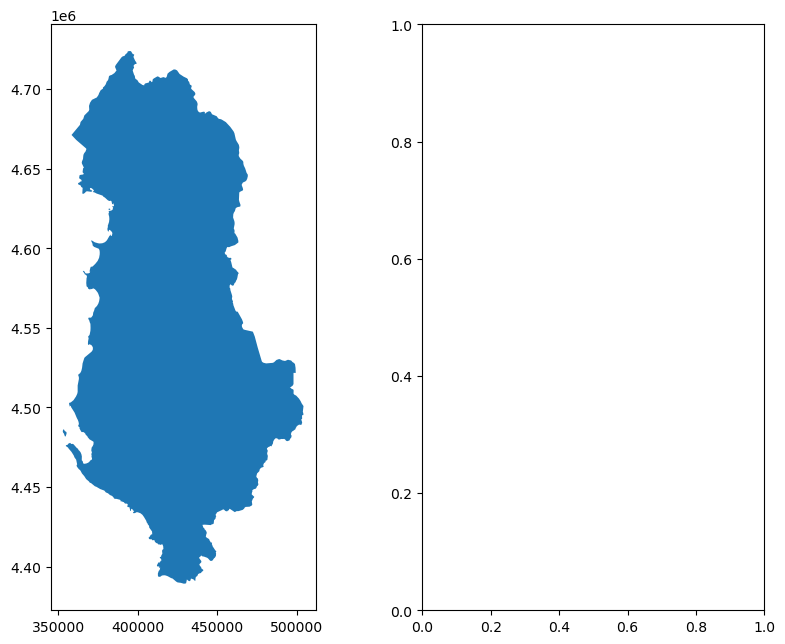

In [7]:
plt.figure(figsize=(15, 35))

#initiate Exclusion container
excluder = atlite.ExclusionContainer(crs=EPSG, res=res)

#plot plain study region first, then add plots where land use codes where added iteratively in the loop
ax = plt.subplot(math.ceil((len(landuses)+1)/3), 3, 1)
region.plot(ax=ax)


# loop through the length of landuses and keep track of index n
for n, landuse in enumerate(landuses):
    print(n, landuse)

    # add a new subplot iteratively
    ax = plt.subplot(math.ceil((len(landuses)+1)/3), 3, n + 2)

    #add exclusion and plot
    excluder.add_raster(landcoverPath, codes=landuse,crs=EPSG)
    #calculate available areas
    masked, transform = shape_availability(region.geometry, excluder)
    #plot it
    region.plot(ax=ax, color="none")
    show(masked, transform=transform, cmap="Greens", ax=ax)
    ax.set_title(f'landuse {landuse} added')

    # calculate elible share
    eligible_share = masked.sum() * excluder.res**2 / region.geometry.item().area

    # Add text box to each subplot in top right corner
    ax.text(0.97, 0.97, f'av. land: {eligible_share:.2%}', 
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))

# Set your exclusions

In [8]:
#initiate Exclusion container
excluder = atlite.ExclusionContainer(crs=EPSG, res=res)

#add landcover exclusions
excluder.add_raster(landcoverPath, codes=[80,111,114,115,116],crs=EPSG)
excluder.add_raster(landcoverPath, codes=[50], buffer=1000 ,crs=EPSG)

#add elevation exclusions
if dem==1: excluder.add_raster(demRasterPath, codes=range(2000,10000), crs=EPSG)

#add slope exclusions
if slope==1: excluder.add_raster(slopeRasterPath, codes=range(20,90), crs=EPSG)

#add north facing exclusion
if nfacing==1: excluder.add_raster(northfacingRasterPath, codes=1, crs=EPSG)


#add exclusions from vector data
if railways==1: excluder.add_geometry(railwaysPath, buffer=100)
if roads==1: excluder.add_geometry(roadsPath, buffer=100)
if airports==1: excluder.add_geometry(airportsPath, buffer=5000)
if waterbodies==1: excluder.add_geometry(waterbodiesPath, buffer=5)
if coastlines==1: excluder.add_geometry(coastlinesPath, buffer=100)
if protectedAreas==1: excluder.add_geometry(protectedAreasPath, buffer=0)

#calculate available areas
masked, transform = shape_availability(region.geometry, excluder)

eligible_share = masked.sum() * excluder.res**2 / region.geometry.item().area
print(f"The eligibility share is: {eligible_share:.2%}")

The eligibility share is: 17.04%


<Axes: title={'center': 'Eligible area (green) 17.04%'}>

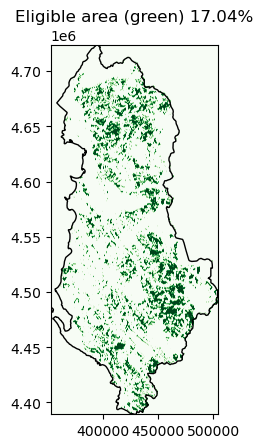

In [9]:
fig, ax = plt.subplots()
excluder.plot_shape_availability(region)

In [10]:
#area filter
def area_filter(boolean_array, min_size=5):
    # Label connected components in the array
    labeled_array, num_features = label(boolean_array)
    
    # Count the number of pixels in each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Create a mask for components that meet the size requirement (ignoring the background)
    large_component_mask = np.zeros_like(component_sizes, dtype=bool)
    large_component_mask[1:] = component_sizes[1:] >= min_size  # Skip the background component (index 0)
    
    # Filter the original array, keeping only large components
    filtered_array = large_component_mask[labeled_array]
    
    return filtered_array

In [11]:
min_pixels_connected = 4
masked_area_filtered = area_filter(masked,min_pixels_connected)

#array to be used 
array = masked_area_filtered

# Convert boolean array to integers (1 for True, 0 for False)
int_array = array.astype(np.uint8)

# Set 0 (False) to be the nodata value
nodata_value = 0

#save eligible land array as .tif file
# Define the metadata for the new file
# You'll need to adjust these parameters based on your specific data
metadata = {
    'driver': 'GTiff',
    'dtype': rasterio.uint8,
    'nodata': nodata_value,
    'width': array.shape[1],
    'height': array.shape[0],
    'count': 1,
    'crs': rasterio.crs.CRS.from_epsg(EPSG),  # WGS84, modify as needed
    'transform': transform,
    'compress': 'LZW' 
}

# Write the array to a new .tif file
if masked_area_filtered in array:
    with rasterio.open(os.path.join(data_path, f'available_land_filtered-min{min_pixels_connected}_{region_name}_EPSG{EPSG}.tif'), 'w', **metadata) as dst:
        dst.write(array, 1)
else:
    with rasterio.open(os.path.join(data_path, f'available_land_total_{region_name}_EPSG{EPSG}.tif'), 'w', **metadata) as dst:
        dst.write(array, 1)    